In [22]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy


In [2]:
data_2020 = pd.read_csv('../data/img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv')

In [3]:
data_2020.Date.unique()

array(['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13'], dtype=object)

In [4]:
#2020
data_2020['DMCast_events'] = 0
data_2020.loc[data_2020['Date'] == '2020-06-18', 'DMCast_events'] = 5
data_2020.loc[data_2020['Date'] == '2020-06-25', 'DMCast_events'] = 25
data_2020.loc[data_2020['Date'] == '2020-07-09', 'DMCast_events'] = 12
data_2020.loc[data_2020['Date'] == '2020-08-06', 'DMCast_events'] = 42
data_2020.loc[data_2020['Date'] == '2020-08-13', 'DMCast_events'] = 38

In [5]:
data_2020['GDM_sev']='low'
data_2020.loc[data_2020['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
data_2020['GDM_inc']='low'
data_2020.loc[data_2020['DM_inc'] > 25, 'GDM_inc'] = 'high'

Low severity: 381
High severity: 118
Proportion: 3.23 : 1


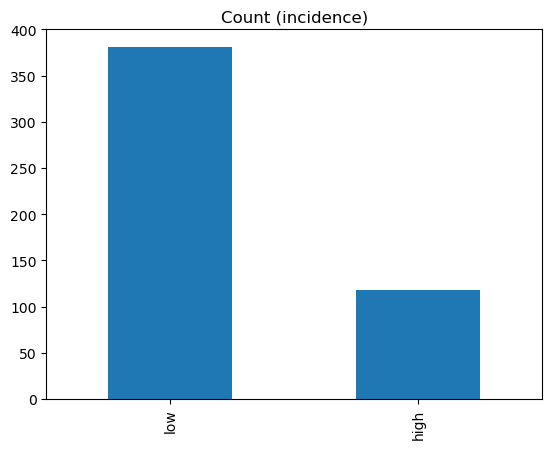

In [8]:
target_count = data_2020.GDM_inc.value_counts()
print('Low severity:', target_count[0])
print('High severity:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (incidence)');

In [85]:
# All high disease panels are clustered on later image dates
# leaving one of these images out will make test set too small

# Better idea: random forest for 2020, report accuracy metrics and kappa score

# Later test global model on hold-out image from 2020

# data_2020[data_2020['GDM_sev']=='high'].Date.unique()

In [9]:
data_2020.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'green_red', 'green_blue', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'DMCast_events', 'GDM_sev',
       'GDM_inc'],
      dtype='object')

In [10]:
# First with no DMCast, just VIs for poster
# Severity
expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_sev'

In [14]:
X = data_2020[expl_vars]
y = data_2020[resp_var]

rus = RandomUnderSampler(random_state=2020)
X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set
SPLIT_RND_SEED = 456
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test

print("Using", len(X_train), "panels for training,", len(y_test), "panels for testing")
print("Train split:\n",
      y_train.value_counts())
print("Test split:\n",
      y_test.value_counts())

Using 37 panels for training, 17 panels for testing
Train split:
 high    19
low     18
Name: GDM_sev, dtype: int64
Test split:
 low     9
high    8
Name: GDM_sev, dtype: int64


In [15]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier with 500 trees 
rf = RandomForestClassifier(n_estimators = 500, 
                                   oob_score=True, 
                                   random_state=12345, # random number to be used, needed to reproduce the same result
                                   verbose=False)
# Train the model using the training sets
rf_model = rf.fit(X_train, y_train)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')

Out-of-bag score estimate: 0.757


In [16]:
# Prediction on test data
y_pred = rf.predict(X_test)

Text(0.5, 1.0, 'RF-UnderSampled 2020 GDM Severity')

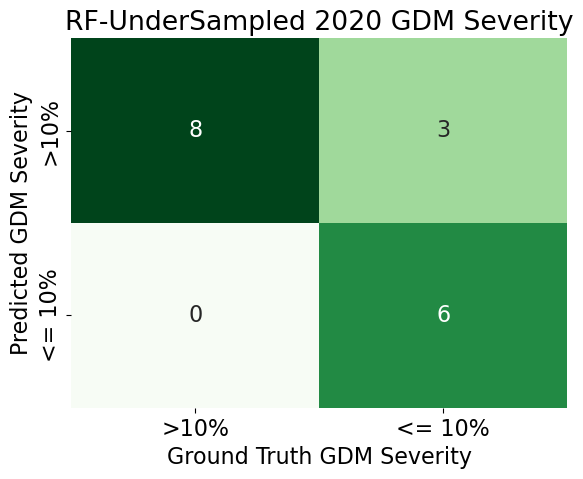

In [17]:
# Confusion (error) Matrix of Prediction
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  
# use seaborn to plot matrix as heatmap    
plt.rc('font', size=16)
p = sns.heatmap(cm,
                annot=True,
                cbar=False,
                cmap="Greens",
               xticklabels=['>10%', '<= 10%'],
               yticklabels=['>10%', '<= 10%'])
plt.xlabel('Ground Truth GDM Severity')
plt.ylabel('Predicted GDM Severity')
plt.title('RF-UnderSampled 2020 GDM Severity')

In [18]:
# Accuracy assessment

accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is {:.3f}'.format(accuracy))

Model accuracy is 0.824


In [31]:
prec, recall, acc, supp = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [32]:
prec

0.8716577540106952

In [33]:
recall

0.8235294117647058

In [36]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]

0.8235294117647058

In [29]:
print('precision: high', prec[0])
print('\nprecision: low', prec[1])

print('\nrecall: high', recall[0])
print('\nrecall: low', recall[1])

precision: high 0.7272727272727273

precision: low 1.0

recall: high 1.0

recall: low 0.6666666666666666


In [19]:
# Classification report
stats = classification_report(y_test, y_pred,
                              labels=None,
                              target_names=["high", "low"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats) 

Classification report:

              precision    recall  f1-score   support

        high       0.73      1.00      0.84         8
         low       1.00      0.67      0.80         9

    accuracy                           0.82        17
   macro avg       0.86      0.83      0.82        17
weighted avg       0.87      0.82      0.82        17



/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_1376/17801454.py:15: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 0.18, 0.02)


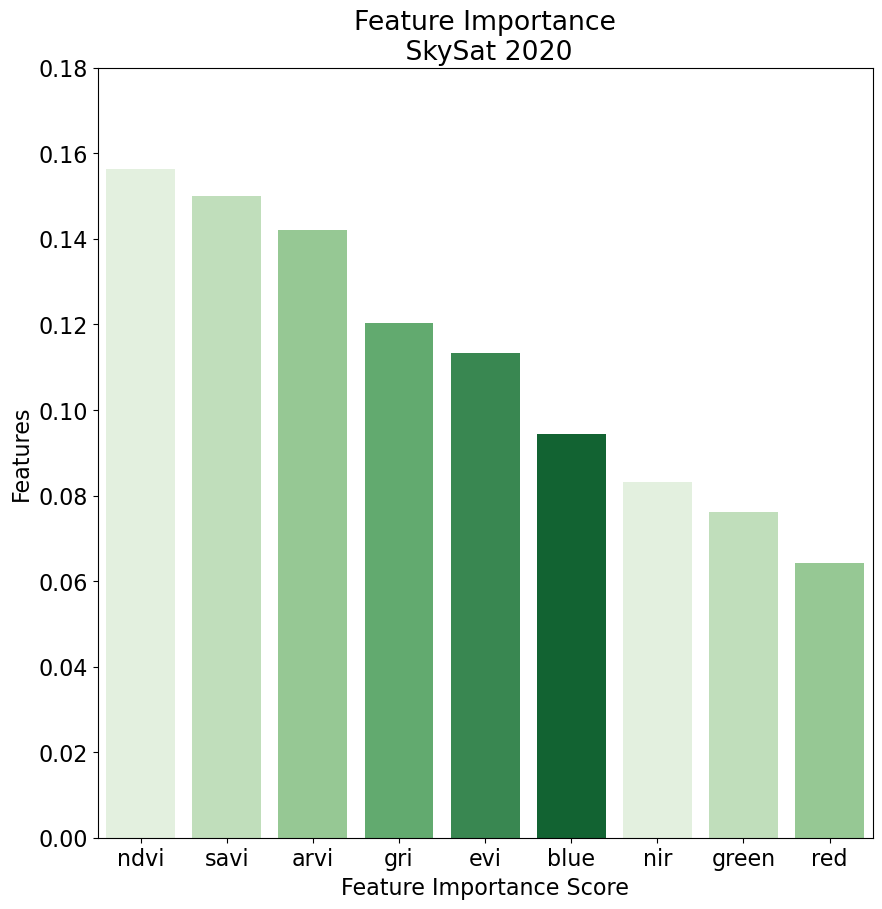

In [20]:
# view the feature scores
feature_scores_20 = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores_20

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]

palette = sns.color_palette("Greens")

# Creating a seaborn bar plot
sns.barplot(x=feature_scores_20.index, y=feature_scores_20, palette=palette)
plt.title("Feature Importance\n SkySat 2020")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.ylim(0, 0.18, 0.02)

# plt.savefig("feature_imp20.svg")
plt.show()


In [51]:
def run_rf(df, expl_vars, resp_var, SPLIT_RND_SEED, rand_state):
    X = df[expl_vars]
    y = df[resp_var]
    
#     rus = RandomUnderSampler(random_state=2020)
#     X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y)  # 70% training and 30% test
    
    from sklearn.ensemble import RandomForestClassifier
    # Create a Gaussian Classifier with 500 trees 
    rf = RandomForestClassifier(n_estimators = 500, 
                                oob_score=True, 
                                random_state=rand_state, # random number to be used, needed to reproduce the same result
                                verbose=False)
    
    rf_model = rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision': [prec],
        'recall': [recall]
    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [52]:
def run_rf_us(df, expl_vars, resp_var, SPLIT_RND_SEED, rand_state):
    X = df[expl_vars]
    y = df[resp_var]
    
    rus = RandomUnderSampler(random_state=2020)
    X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test
    from sklearn.ensemble import RandomForestClassifier
    # Create a Gaussian Classifier with 500 trees 
    rf = RandomForestClassifier(n_estimators = 500, 
                                oob_score=True, 
                                random_state=rand_state, # random number to be used, needed to reproduce the same result
                                verbose=False)
    
    rf_model = rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision': [prec],
        'recall': [recall]
    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [53]:
rf_nous = run_rf(data_2020, expl_vars, resp_var, 678, 2020)
rf_nous

,cohen_kappa,accuracy_score,precision,recall
0,-0.021798,0.933333,0.895495,0.933333


In [54]:
res_1 = run_rf_us(data_2020, expl_vars, resp_var, 678, 2021)

In [55]:
res_2 = run_rf_us(data_2020, expl_vars, resp_var, 911, 2022)

In [56]:
res_3 = run_rf_us(data_2020, expl_vars, resp_var, 941, 2023)

In [57]:
pd.concat([res_1, res_2, res_3])

,cohen_kappa,accuracy_score,precision,recall
0,0.534247,0.764706,0.783193,0.764706
0,0.648276,0.823529,0.829248,0.823529
0,0.521127,0.764706,0.777184,0.764706


In [58]:
import random
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [59]:
expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_sev'

results_alldata = []
for r in rand_list:
    res_df = run_rf(data_2020, expl_vars, resp_var, r, 2020)
    
    results_alldata.append(res_df)

/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [60]:
results_alldata_df = pd.concat(results_alldata)

results_alldata_df.head()

,cohen_kappa,accuracy_score,precision,recall
0,0.157303,0.940000,0.919365,0.940000
0,-0.021798,0.933333,0.895495,0.933333
0,0.000000,0.946667,0.896178,0.946667
0,-0.011994,0.940000,0.895839,0.940000
0,0.182561,0.946667,0.928559,0.946667


In [65]:
results_alldata_df.mean()

cohen_kappa       0.063680
accuracy_score    0.939667
precision         0.909092
recall            0.939667
dtype: float64

In [63]:
# Try with undersampling

rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_sev'

results_us = []
for r in rand_list:
    res_df = run_rf_us(data_2020, expl_vars, resp_var, r, 5678)
    
    results_us.append(res_df)

results_us_df = pd.concat(results_us)

results_us_df.head()

,cohen_kappa,accuracy_score,precision,recall
0,0.527778,0.764706,0.764706,0.764706
0,0.413793,0.705882,0.710784,0.705882
0,0.767123,0.882353,0.905882,0.882353
0,0.527778,0.764706,0.764706,0.764706
0,0.527778,0.764706,0.764706,0.764706


In [64]:
results_us_df.mean()

cohen_kappa       0.505110
accuracy_score    0.752353
precision         0.769480
recall            0.752353
dtype: float64

In [66]:
# Try with disease incidence

# Try with undersampling

rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_inc'

results_inc = []
for r in rand_list:
    res_df = run_rf_us(data_2020, expl_vars, resp_var, r, 5678)
    
    results_inc.append(res_df)

results_inc_df = pd.concat(results_inc)

results_inc_df.mean()

cohen_kappa       0.741887
accuracy_score    0.870986
precision         0.876382
recall            0.870986
dtype: float64